In [1]:
from changed_content_similarity import TextDiff
%run functions_wiki.py

In [2]:
A = 'Apple is an American company.'
B = 'Apple Inc is an American multinational technology company founded in 1978.'
C = 'Apple Inc. is an American multinational technology company founded in 1976.'

In [3]:
a,b = TextDiff(A,B).getDiff(), TextDiff(B,C).getDiff()

In [4]:
a,b

('{+Inc+} [-company.-] {+multinational technology company founded in 1978.+}',
 '[-Inc-] {+Inc.+} [-1978.-] {+1976.+}')

In [5]:
# ## calculate similarty of two random edits 
# import random

# sample = random.sample(data.index.tolist(), 100)
# from itertools import combinations
# simi = []
# for i, j in combinations(sample,2):
#     a, b = TextDiff(data['text'][i-1],data['text'][i]).getDiff(), TextDiff(data['text'][j-1],data['text'][j]).getDiff()
#     v1, v2 = text_to_vector(a), text_to_vector(b)
#     simi.append(get_cosine(v1,v2))
# import matplotlib.pyplot as plt
# import seaborn as sns

# %matplotlib inline 

# import matplotlib

## Parse top user edit session 

In [6]:
# data = pd.read_csv("../../data/NeXT_5.txt", sep="\t")
# data['timestamp'] = pd.to_datetime(data['timestamp'])
# data = data.sort_values('timestamp').reset_index(drop=True)
# data['text'] = data['text'].astype('str')

# data.head()

In [7]:
def mark_sessionid(x, marker):
    'x is user edit timestamp, return session id'
    x = x.values
    intervals = [61]
    for i in range(1, len(x)):
        intervals.append((x[i]-x[i-1]).astype('timedelta64[m]').astype(int))
    intervals = np.where(np.array(intervals)>marker, 1, 0)
    session_id, tmpid = [0], 0
    for i in intervals[1:]:
        if i > 0:
            tmpid += 1
        session_id.append(tmpid)
    return np.array(session_id)

In [8]:
def parse_user_session(file_path, N=3, marker = 60):
    data = pd.read_csv(file_path, sep="\t")
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data = data.sort_values('timestamp').reset_index(drop=True)
    data['text'] = data['text'].astype('str')
#     N = int(np.round(len(set(data['user']))*percent))
    sessions = []
    top_users = data['user'].value_counts().index.tolist()[:N]
    for user in top_users:
        print(user)
        mask_user = data['user'] == user
        tmp = data[mask_user]  # user's edits in tmp dataframe
        # mark session id
        a = mark_sessionid(tmp['timestamp'], marker)
        g = tmp.groupby(a)
        for key, df in g:
            default = {'username':user, 'session_id':key, 'start':min(df['timestamp']), 
                       'end':max(df['timestamp']), 'edit_num':len(df)}
            index = df.index.tolist()
            text1, text2 = data.ix[index[0]-1,'text'], data.ix[index[-1],'text']
            default['changed_text'] = TextDiff(text1,text2).getDiff()
            default['text_word_num'] = len(default['changed_text'].split(" "))
            if default['edit_num'] > 1:
                default['duration'] = (default['end'] - default['start']).total_seconds()/60  # chansfer into mins
            else:
                default['duration'] = np.nan
            sessions.append(default)
    sessions = pd.DataFrame(sessions)
    sessions['id'] = sessions['username'] + "_" + sessions['session_id'].astype('str')
    sessions = sessions.sort_values('start').reset_index(drop=True)
    return sessions

In [9]:
# def preprocessing(text):
#     text = re.sub(r'[^a-zA-Z0-9]', " ", text)
#     text = re.sub(r' +', " ", text)
#     return text
# sessions['changed_text'] = sessions['changed_text'].apply(preprocessing)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [11]:
def build_network(sessions, cosine_threshold=0.4):
    # mark content similarity 
    vect = CountVectorizer(lowercase=True,stop_words='english',binary=True).fit(sessions['changed_text'])
    vect_matrix = vect.transform(sessions['changed_text']).toarray()
    simi = np.where(cosine_similarity(vect_matrix)>cosine_threshold,1,0)
    for i in np.arange(np.shape(simi)[0]):
        simi[i,i] = 0
    G = nx.from_numpy_matrix(simi, create_using=nx.Graph())
    # mark time similarity 
    for i in range(1,len(sessions)):
        if (sessions.ix[i,'start'] - sessions.ix[i-1,'end']).total_seconds()/(60*60*3) < 1:  
            G.add_edge(i,i-1)
    return G

In [12]:
def extract_network_topology(G, nodes = []):
    if len(nodes):
        G = G.subgraph(nodes)
    default = {"isolate_nodes": np.nan, "connected_nodes":np.nan, "density":np.nan, 'total_nodes':np.nan}
    default['isolate_nodes'] = len(list(nx.isolates(G)))
    default['total_nodes'] = len(list(G.nodes()))
    default['connected_nodes'] = default['total_nodes'] - default['isolate_nodes']
    default['density'] = nx.density(G)
    return default

In [13]:
# data['year'] = data['timestamp'].apply(lambda x: x.year)
# sessions['year'] = sessions['start'].apply(lambda x: x.year)

# g = data.groupby('year')
# bursts = {}
# for key, df in g:
#     bursts[key] = cal_burstiness(get_time_intervals(df))

# bursts = pd.DataFrame([bursts.keys(), bursts.values()], index=['year','burst']).T

# g = sessions.groupby('year')
# network_info = []
# for key, df in g:
#     nodes = np.arange(0, max(df.index))
#     network_info.append(extract_network_topology(G, nodes=nodes))

# tmp = pd.DataFrame(network_info)

# tmp['year'] = set(sessions.year)

# tmp2 = pd.merge(bursts, tmp, 'left')

# tmp2

# tmp2.ix[1:,['burst','connected_nodes','isolate_nodes']].plot(secondary_y='burst')
# plt.show()

# tmp2.ix[1:,['burst', 'density']].plot(secondary_y='burst')
# plt.show()

## plot network dynamics

In [14]:
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

In [15]:
sessions = parse_user_session(file_path="./NeXT_5.txt", N = 5)

JoshuacUK
Tomhormby
Maury Markowitz
Letdorf
SandyGeorgia


In [16]:
G = build_network(sessions,0.4)

In [17]:
sessions.head()

,changed_text,duration,edit_num,end,session_id,start,text_word_num,username,id
0,[-The company founded by-] {+In 1985+} [-in 19...,39.566667,2,2002-05-31 09:42:36,0,2002-05-31 09:03:02,1058,Maury Markowitz,Maury Markowitz_0
1,"[-Sculley]]-] {+Sculley]],+} [-University]], a...",NaN,1,2002-06-04 12:18:06,1,2002-06-04 12:18:06,561,Maury Markowitz,Maury Markowitz_1
2,"{+the helm of+} [-Sculley]], which-] {+Sculley...",11.816667,2,2002-06-06 06:21:49,2,2002-06-06 06:10:00,647,Maury Markowitz,Maury Markowitz_2
3,{+\n \nThe solution to this problem today is t...,2.650000,4,2002-06-06 11:16:49,3,2002-06-06 11:14:10,338,Maury Markowitz,Maury Markowitz_3
4,[-This led to-] {+He was stripped of most of+}...,21.366667,5,2002-06-06 13:18:52,4,2002-06-06 12:57:30,308,Maury Markowitz,Maury Markowitz_4


In [18]:
extract_network_topology(G)

{'connected_nodes': 115,
 'density': 0.008483033932135729,
 'isolate_nodes': 53,
 'total_nodes': 168}

In [19]:
N = 5
mapping = dict(zip(set(sessions['username']), [plt.cm.Paired(c) for c in range(0,N)]))
color = sessions['username'].map(mapping)

In [20]:
from networkx.drawing.nx_agraph import graphviz_layout

In [21]:
pos = graphviz_layout(G)

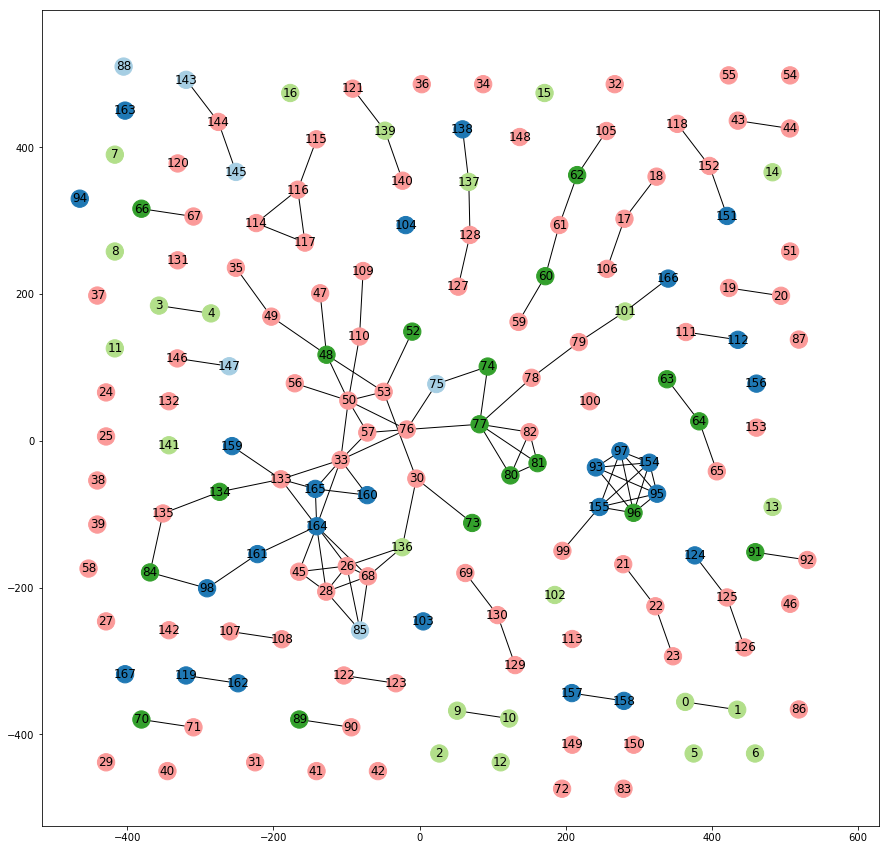

In [22]:
fig = plt.figure(figsize=(15,15))
nx.draw_networkx(G, pos=pos, node_color=color)
plt.show()

In [23]:
G[30]

AtlasView({53: {'weight': 1}, 73: {'weight': 1}, 136: {'weight': 1}})

In [24]:
sessions.ix[[30,136],:]

,changed_text,duration,edit_num,end,session_id,start,text_word_num,username,id
30,{+Jobs recruited [[Paul Rand]] in 1986 to desi...,1.25,2,2006-06-20 14:55:46,13,2006-06-20 14:54:31,50,JoshuacUK,JoshuacUK_13
136,"[-As-] {+\n \nAs+} [-(RAM) (hence the name),-]...",NaN,1,2008-05-13 22:05:05,19,2008-05-13 22:05:05,372,Maury Markowitz,Maury Markowitz_19


In [25]:
print(sessions.ix[30,'changed_text'])

{+Jobs recruited [[Paul Rand]] in 1986 to design NeXT's cube logo for US$100,000. <ref>{{cite book | first=Steven | last=Heller | coauthors=Helfand, Jessica; Lois, George | title=Paul Rand | publisher=Phaidon Press | year=2000 | pages=256 | id=ISBN 0-7148-3994-9}}</ref> <ref>{{cite web | year=2004 | title=Paul Rand | format=HTML | work=logolog | url=http://38one.com/cleverblog/paul-rand}}</ref>+}


In [26]:
print(sessions.ix[136,'changed_text'])

[-As-] {+
 
As+} [-(RAM) (hence the name),-] {+(RAM),+} [-performance. A megaflop denotes the computer-] [-in flops (FLoating point Operations Per Second), which are used to measure computer performance.-] {+(hence the name "3M").+} [-[[1985]], telling-] {+[[1985]]. He told+} [-of directors-] {+he was leaving to set up a new computer company, and that he would be taking several Apple employees from the SuperMicro division with him. He also told the board+} [-Apple-] {+them+} [-Jobs-] {+
 
Jobs+} [-In 1986, Jobs recruited the famous graphic designer [[Paul Rand]] to create a brand identity costing $100,000.<ref name="rand">{{cite book | first=Steven | last=Heller | coauthors=Helfand, Jessica; Lois, George | title=Paul Rand | publisher=Phaidon Press | year=2000 | pages=pg. 256|id=ISBN 0-7148-3994-9}}</ref> Rand created a 100-page brochure detailing the brand, including the precise angle used for the logo (28°) and a new company name, NeXT.<ref name="rand"/> The first major outside invest

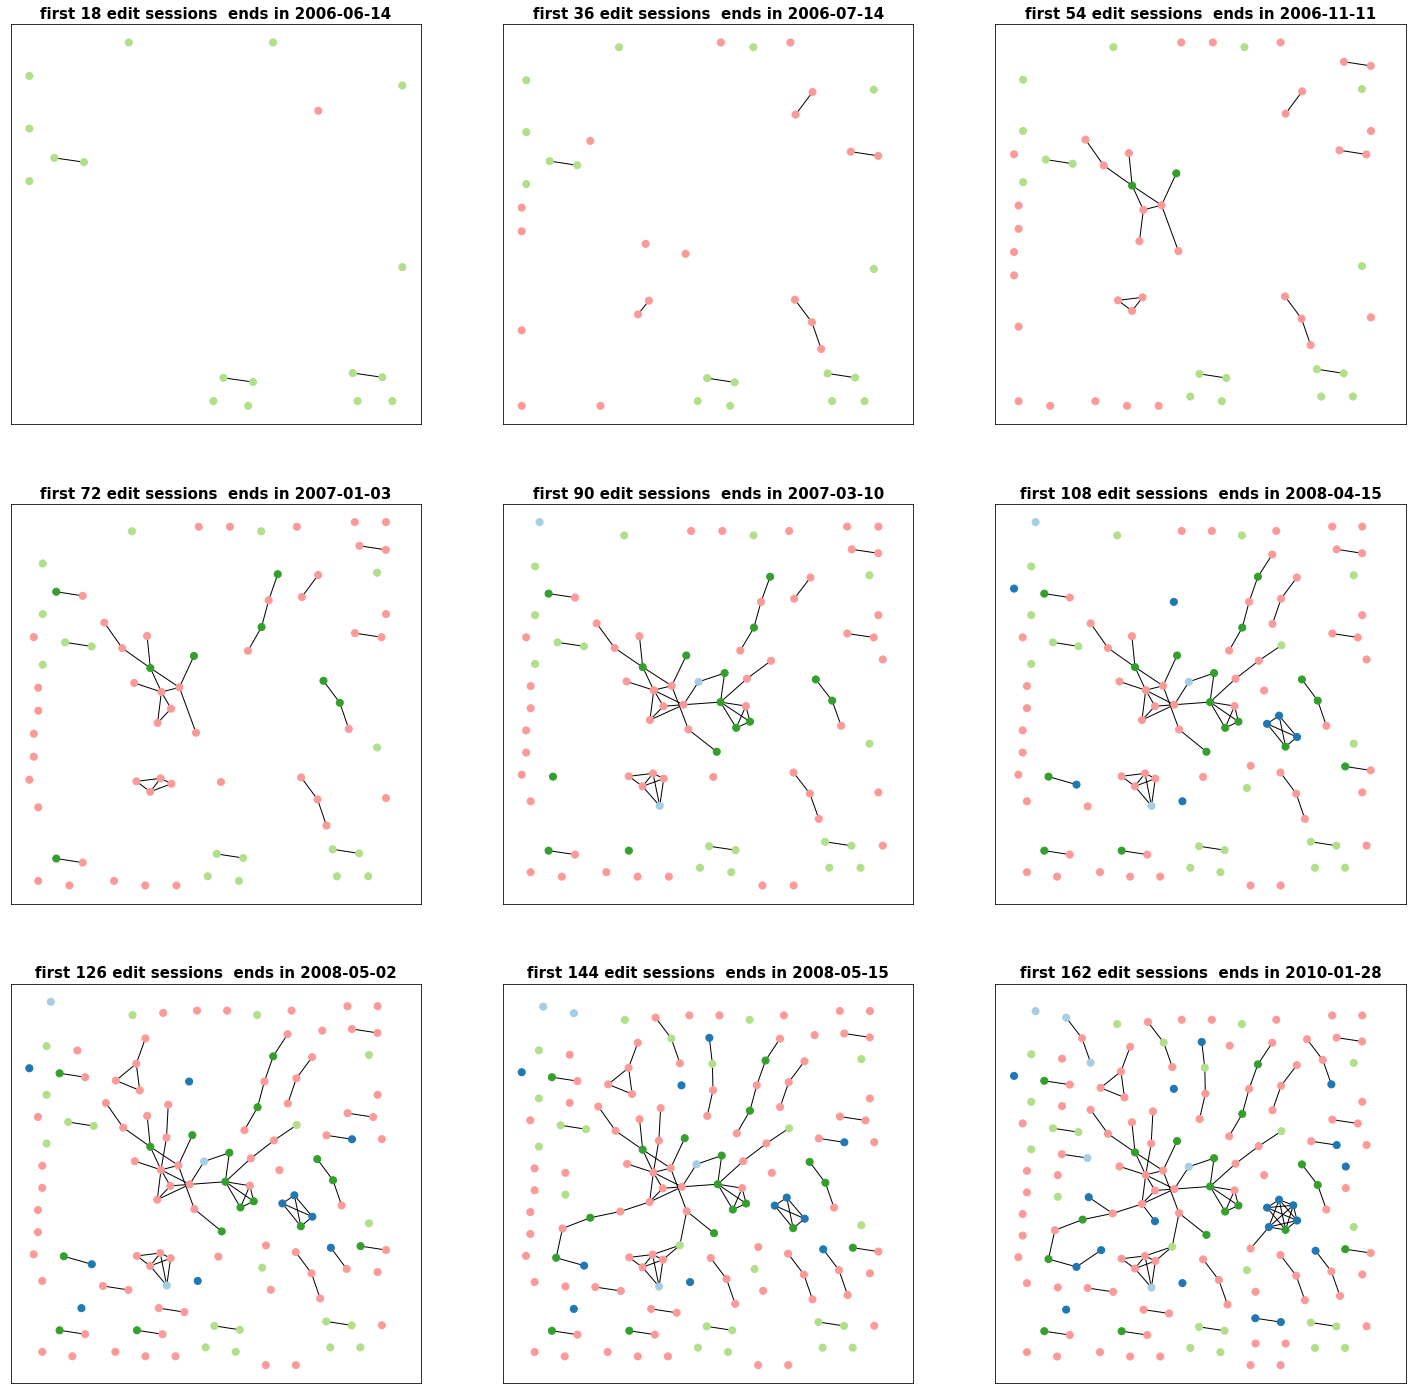

In [27]:
nodes_per_graph = len(G.nodes()) // 9
fig = plt.figure(figsize=(25,25))
cnt = 1
for i in np.arange(nodes_per_graph,len(sessions),nodes_per_graph):
    G1 = G.subgraph(np.arange(i))
    fig.add_subplot(3,3,cnt)
    nx.draw_networkx(G1, node_color=color.values[:i], with_labels=False, node_size=50, pos=pos)
    plt.title("first %s edit sessions" %i + "  ends in "+str(sessions.ix[i,'end'].date()) ,size=15, weight='bold')
    frame1 = plt.gca()
    frame1.get_xaxis().set_visible(False)
    frame1.get_yaxis().set_visible(False)
    cnt += 1
# fig.savefig('/Users/Nico/Desktop/collaboration_network.png',dpi=300, bbox_inches='tight')
plt.show()

In [34]:
# This doesn't seem to work (no attribute 'values' in degree object)
#plt.hist(G.degree().values(),bins=15)
#plt.show()

In [35]:
for i in nx.connected_components(G):
    if len(i)>1:
        print(len(i))
        print(set(sessions.ix[i,'username']))
        print(min(sessions.ix[i,'start']))
        print(max(sessions.ix[i,'end']))
        print("======")

2
{'Maury Markowitz'}
2002-05-31 09:03:02
2002-06-04 12:18:06
2
{'Maury Markowitz'}
2002-06-06 11:14:10
2002-06-06 13:18:52
2
{'Maury Markowitz'}
2002-07-02 11:58:19
2002-07-02 13:26:11
3
{'JoshuacUK'}
2006-06-14 16:56:42
2008-04-14 22:09:49
2
{'JoshuacUK'}
2006-06-15 06:56:46
2006-06-15 09:51:51
3
{'JoshuacUK'}
2006-06-15 14:29:08
2006-06-15 18:36:47
41
{'SandyGeorgia', 'Letdorf', 'Maury Markowitz', 'Tomhormby', 'JoshuacUK'}
2006-06-18 20:45:29
2011-09-09 20:44:52
2
{'JoshuacUK'}
2006-11-04 17:48:57
2006-11-05 10:33:31
5
{'Tomhormby', 'JoshuacUK'}
2006-11-19 15:37:41
2008-04-14 16:48:35
3
{'Tomhormby', 'JoshuacUK'}
2006-11-22 15:22:38
2006-11-22 17:14:45
2
{'Tomhormby', 'JoshuacUK'}
2006-11-25 19:16:27
2006-11-25 20:31:55
3
{'JoshuacUK'}
2006-12-10 16:24:59
2008-05-05 12:48:32
2
{'Tomhormby', 'JoshuacUK'}
2007-01-03 14:58:30
2007-01-03 16:15:37
2
{'Tomhormby', 'JoshuacUK'}
2007-03-10 18:54:06
2007-03-10 22:35:09
2
{'Tomhormby', 'JoshuacUK'}
2007-03-11 07:26:10
2007-03-11 08:24:21
7
{'